# Map of Covid-19 Cases in São Paulo - Brazil

Este caderno é direcionado à produção de um mapa das mortes e casos em todo o estado devido ao Covid-19.


Como principal fonte de dados, usaremos os dados oficiais da Secretaria de Saúde do Estado, disponibilizados em https://www.seade.gov.br/coronavirus/.

Para os limites municipais, usaremos o conjunto de dados de municípios de São Paulo do catálogo de dados do Banco Mundial (https://datacatalog.worldbank.org/dataset/sao-paulo-municipalities) 


In [1]:
import pandas as pd
import ssl
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et



In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
dados_de_covid_por_municipio = pd.read_csv(
    "http://www.seade.gov.br/wp-content/uploads/2020/04/Dados-covid-19-Est-SP.csv",
    sep = ";",
    encoding = "latin" )

dados_de_covid_por_municipio.head(4)

,Total de casos,Casos por dia,Óbitos por dia,Data,Município,Mun_Total de casos,Mun_Total de óbitos,Cód IBGE,Latitude,Longitude,Municípios atingidos
0,1.0,1.0,NaN,26 fev,Águas de Lindóia,1,1,3500501.0,"-22,4733","-46,6314",162.0
1,0.0,0.0,NaN,27 fev,Águas de São Pedro,1,0,3500600.0,"-22,5977","-47,8734",NaN
2,0.0,0.0,NaN,28 fev,Agudos,2,1,3500709.0,"-22,4694","-48,9863",NaN
3,2.0,1.0,NaN,29 fev,Americana,3,2,3501608.0,"-22,7374","-47,3331",NaN


In [3]:
# Importando o shapefile com geopandas

mapa_dos_municipios_de_sp = gpd.read_file("shapefiles/sao_paulo.shp")

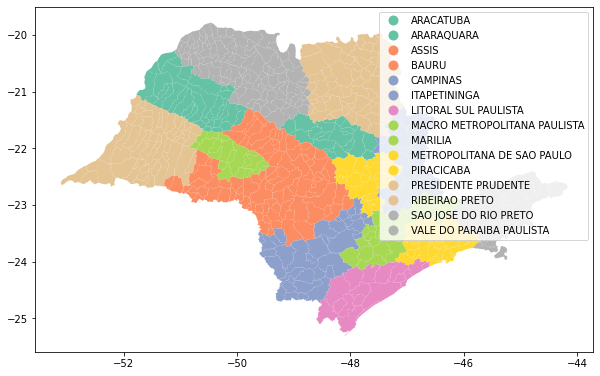

In [4]:
fig, ax = plt.subplots(figsize = (10,10))

# Plotando o mapa só para ver como fica

mapa_dos_municipios_de_sp.plot(column='NOMEMESO', 
                         categorical=True, 
                         legend=True, 
                         figsize=(10,6),
                         markersize=45, 
                         cmap="Set2", ax=ax);

In [5]:
mapa_dos_municipios_de_sp["CODMUNIC"] = mapa_dos_municipios_de_sp["CODMUNIC"].astype(float)
mapa_dos_municipios_de_sp_com_dados = mapa_dos_municipios_de_sp.merge(dados_de_covid_por_municipio, left_on="CODMUNIC", right_on="Cód IBGE", how = "left")
mapa_dos_municipios_de_sp_com_dados["CODMUNIC"]


0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
655    3556305.0
656    3557105.0
657    3557154.0
658    3557204.0
659    3557303.0
Name: CODMUNIC, Length: 660, dtype: float64

In [6]:
mapa_dos_municipios_de_sp_com_dados["Mun_Total de óbitos"] = mapa_dos_municipios_de_sp_com_dados["Mun_Total de óbitos"].fillna(0)
mapa_dos_municipios_de_sp_com_dados["Mun_Total de casos"] = mapa_dos_municipios_de_sp_com_dados["Mun_Total de casos"].fillna(0)

mapa_dos_municipios_de_sp_com_dados["obitos_categorizados"] = pd.cut(mapa_dos_municipios_de_sp_com_dados["Mun_Total de óbitos"],
                                                    bins = [-1,1,3,6,10,50,200, 100000000],
                                                   labels = ["0", "1-3", "4-6", "6-10", "11-50","51-200", ">201"])

mapa_dos_municipios_de_sp_com_dados["casos_categorizados"] = pd.cut(mapa_dos_municipios_de_sp_com_dados["Mun_Total de casos"],
                                                    bins = [-1,1, 10,50,500,1000, 100000000],
                                                   labels = ["0", "1-10", "11-50", "51-500","501-1000", ">1000"])

In [7]:
# Encontrando a data da tabela

datas_registradas = dados_de_covid_por_municipio["Data"][dados_de_covid_por_municipio["Data"].notnull()]

data_dos_dados = datas_registradas.values[-1]
data_dos_dados

'12 abr'

In [8]:
def plote_mapa_de_sp_com_dados(tabela_geopandas, coluna_dos_dados):
    fig, ax = plt.subplots()
    ax = mapa_dos_municipios_de_sp_com_dados.plot(column=coluna_dos_dados,
                         categorical=True, 
                         legend=True, 
                         figsize=(10,6),
                         markersize=45,
                         cmap = "Reds",
                         ax=ax);
    # Removendo os eixos x e y para ficar mais bonitinho
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    

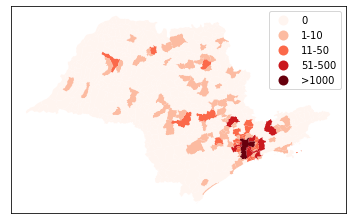

In [9]:
plote_mapa_de_sp_com_dados(mapa_dos_municipios_de_sp_com_dados, "casos_categorizados")
plt.savefig("fig/casos_sp_" + data_dos_dados + ".png", dpi=300)

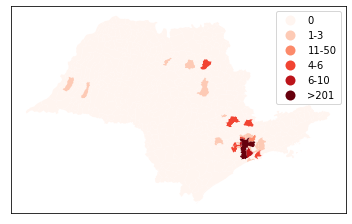

In [10]:
plote_mapa_de_sp_com_dados(mapa_dos_municipios_de_sp_com_dados, "obitos_categorizados")
plt.savefig("fig/obitos_sp_" + data_dos_dados + ".png", dpi=300)
